# Runtime comparisons for duplicate node exclusion methods

In [100]:
import pandas
import matplotlib.pyplot
import seaborn
import numpy
import sklearn.metrics
import qgrid

%matplotlib inline

In [81]:
feature_df = pandas.read_table('dwpc.tsv.gz')
part_df = pandas.read_table('../data/partition.tsv.gz')

In [44]:
# Create a spread dataframe of runtimes
runtime_df = feature_df.pivot_table(values='seconds', index=['compound_id', 'disease_id', 'metapath'], columns='unique_nodes')
# runtime_df = runtime_df.dropna() # use if only reading a part of `dwpc.tsv.gz`

# milliseconds per query
1000 * runtime_df.mean()

unique_nodes
False       126.109162
expanded    170.168882
nested      174.093880
dtype: float64

In [45]:
# Create a spread dataframe of Path Counts
PC_df = feature_df.pivot_table(values='PC', index=['compound_id', 'disease_id', 'metapath'], columns='unique_nodes')
# PC_df = PC_df.dropna() # use if only reading a part of `dwpc.tsv.gz`
len(PC_df)

In [46]:
# Check that the two methods of duplicate node exclusion produce the same results
all(PC_df.expanded == PC_df.nested)

True

/home/dhimmels/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


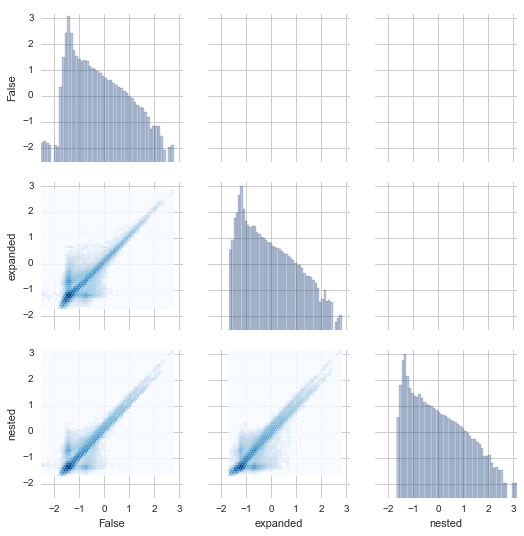

In [48]:
seaborn.set_style('whitegrid')
logtime_df = numpy.log10(runtime_df)
grid = seaborn.PairGrid(logtime_df)
grid.map_diag(seaborn.distplot, kde=False, hist_kws={'log': True})
grid.map_lower(matplotlib.pyplot.hexbin, bins='log', cmap='Blues', gridsize=50, linewidths=0)
lim = logtime_df.min().min(), logtime_df.max().max()
grid.set(xlim=lim, ylim=lim)
seaborn.despine(top=True, right=True, left=True, bottom=True)

/home/dhimmels/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


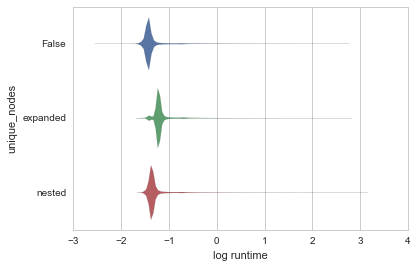

In [147]:
ax = seaborn.violinplot(x='value', y='unique_nodes', data=pandas.melt(logtime_df), inner=None, cut=0, linewidth=0.1)
matplotlib.pylab.xlabel('log runtime');

In [150]:
runtime_df['expanded - False'] = runtime_df['expanded'] - runtime_df['False']
runtime_df['nested - False'] = runtime_df['nested'] - runtime_df['False']
runtime_df['nested - expanded'] = runtime_df['nested'] - runtime_df['expanded']

/home/dhimmels/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


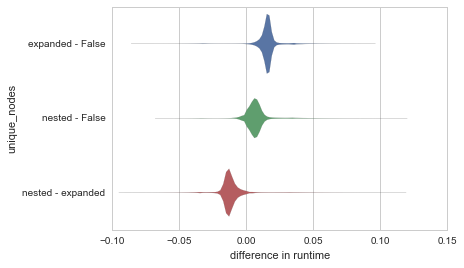

In [155]:
paired_columns = ['expanded - False', 'nested - False', 'nested - expanded']
theta = 100
paired_df = numpy.arcsinh(theta * runtime_df[paired_columns]) / theta
ax = seaborn.violinplot(x='value', y='unique_nodes', data=pandas.melt(paired_df), inner=None, cut=0, linewidth=0.1)
matplotlib.pylab.xlabel('difference in runtime');

# PC differences

In [157]:
# Filter for differing rows
disagree = PC_df['False'] != PC_df['nested']
'{:.02f}% of path counts were affected by the unique node constraint'.format(100 * disagree.sum() / len(PC_df))

'2.76% of path counts were affected by the unique node constraint'

In [158]:
# runtime differences in milliseconds for discordant path counts
1000 * runtime_df[disagree].mean()

unique_nodes
False                 919.888987
expanded             1185.779167
nested               1248.076861
expanded - False      265.890180
nested - False        328.187874
nested - expanded      62.297694
dtype: float64

In [159]:
# runtime differences in milliseconds for discordant path counts
1000 * runtime_df[-disagree].mean()

unique_nodes
False                103.580249
expanded             141.344018
nested               143.612293
expanded - False      37.763769
nested - False        40.032044
nested - expanded      2.268275
dtype: float64

In [136]:
def metapath_summarize(df):
    disagree = df['False'] != df['nested']
    row = pandas.Series()
    row['pct_affected'] = 100 * sum(disagree) / len(df)
    row['mean_PC_with_dups'] = df['False'].mean()
    row['mean_PC_without_dups'] = df['nested'].mean()
    row['mean_pct_PC_increase'] = 100 * row['mean_PC_with_dups'] / row['mean_PC_without_dups'] - 100
    neg_df = df[df.indication == 0]
    pos_df = df[df.indication == 1]
    row['mean_pct_PC_increase_nonind'] = 100 * neg_df['False'].mean() / neg_df['nested'].mean() - 100
    row['mean_pct_PC_increase_ind'] = 100 * pos_df['False'].mean() / pos_df['nested'].mean() - 100
    
    row['auroc_dup'] = sklearn.metrics.roc_auc_score(df['indication'], df['False'])
    row['auroc_nodup'] = sklearn.metrics.roc_auc_score(df['indication'], df['nested'])
    row['auroc_diff'] = row['auroc_dup'] - row['auroc_nodup']
    
    return row

PC_merged_df = part_df.merge(PC_df.reset_index())
metapath_df = PC_merged_df.groupby('metapath').apply(metapath_summarize).fillna(0)
metapath_df = metapath_df.sort_values('pct_affected', ascending=False)
metapath_df['indication_metaedge'] = metapath_df.index.str.contains(r'CiD|DiC').astype(int).astype(str)
metapath_df.reset_index().to_csv('unique-nodes-metapaths.tsv', sep='\t', index=False)

In [160]:
grid_options = {
    'forceFitColumns': False,
    'defaultColumnWidth': 200,
    'editable': False,
    #'fullWidthRows': True,
    'syncColumnCellResize': True,
    #'forceFitColumns': True,
    'rowHeight': 28,
    #'enableColumnReorder': False,
    #'enableTextSelectionOnCells': True,
}
qgrid.show_grid(metapath_df, grid_options=grid_options, precision=2)

In [121]:
'{:.02f}% of metapaths had diminished AUROCs when exlcuding duplicate nodes.'.format(100 * (metapath_df.auroc_diff > 0).mean())

'22.23% of metapaths had diminished AUROCs when exlcuding duplicate nodes.'

In [128]:
pct_suffer = metapath_df.query('auroc_diff > 0').indication_metaedge.mean() * 100
'{:.02f}% of AUROC-suffering metapaths contained an indication metaedge.'.format(pct_suffer)

'63.41% of AUROC-suffering metapaths contained an indication metaedge.'

In [141]:
pct_suffer = metapath_df.query('auroc_diff > 0.005').indication_metaedge.astype(int).mean() * 100
'{:.02f}% of AUROC-suffering (> 0.005) metapaths contained an indication metaedge.'.format(pct_suffer)

'100.00% of AUROC-suffering (> 0.005) metapaths contained an indication metaedge.'

In [ ]:
metapath_df.query('indication_metaedge == "0"')